# MS2 Extraction

With MS1 features of interest determined by peak detection, corresponding tandem mass spectra, if available, must be extracted and assigned to the MS1 parent ion feature. 
For data independent acquisition, we use non-*m/z* dimensions to assign fragments; for instance, drift time and retention time are used to match fragments in LC-IMS-MS/MS. 
These additional separations enable better attribution of MS2 ions to parent ions, a form of deconvolution inherent in the acquisition, but convolution artifacts can still occur. 

Explicit, algorithmic deconvolution has been implemented such that MS1 and MS2 features overlapping in non-*m/z* separation dimensions are disambiguated to minimize false assignments.
In this form of deconvolution, the profile(s) of non-*m/z* separation dimensions are used to identify only those ions in the MS2 with distributions that correspond to the precursor ion distribution.
This technique simultaneously excludes MS2 ions arising from noise or chemical background, while also attributing MS2 ions only to precursor ions with similar separation distributions.

## Drift Time Offset

In these data, the mass analyzer connected to the drift tube acts in itself like a miniature ion mobility separation aparatus, wherein separations are a function of both the *m/z* of the ion as well as the voltage applied in the collision cell.
As such, when an ion in the MS1 experiences a collsion energy of 0 eV, while its fragment ions experience higher collision energies (in this example, 20 eV), their reported drift times will be "offset" proportional to the collision energy difference and neutral loss.
That is, the MS2 ions, under higher voltage, will travel faster than the corresponding MS1 ions, and thus will have a lower reported drift time.

To demonstrate, we'll visualize the drift time dimension of a selected precursor and its putative MS2 fragments.

In [1]:
import deimos
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ms1 = deimos.load('example_data.h5', key='ms1', columns=['mz', 'drift_time', 'retention_time', 'intensity'])
ms2 = deimos.load('example_data.h5', key='ms2', columns=['mz', 'drift_time', 'retention_time', 'intensity'])

In [3]:
ms1 = deimos.threshold(ms1, threshold=100)
ms2 = deimos.threshold(ms2, threshold=100)

In [4]:
# get maximal data point
mz_i, dt_i, rt_i, intensity_i = ms1.loc[ms1['intensity'] == ms1['intensity'].max(), :].values[0]

# subset the raw data
precursor = deimos.slice(ms1,
                       by=['mz', 'drift_time', 'retention_time'],
                       low=[mz_i - 0.1, dt_i - 1, rt_i - 1],
                       high=[mz_i + 0.2, dt_i + 1, rt_i + 2])

# putative fragments
fragment_profile = deimos.slice(ms2,
                                by=['drift_time', 'retention_time'],
                                low=[dt_i - 1.5, rt_i - 1],
                                high=[dt_i + 1, rt_i + 2])

In [5]:
fragment_dt = deimos.collapse(fragment_profile, keep='drift_time').sort_values(by='drift_time')
precursor_dt = deimos.collapse(precursor, keep='drift_time').sort_values(by='drift_time')

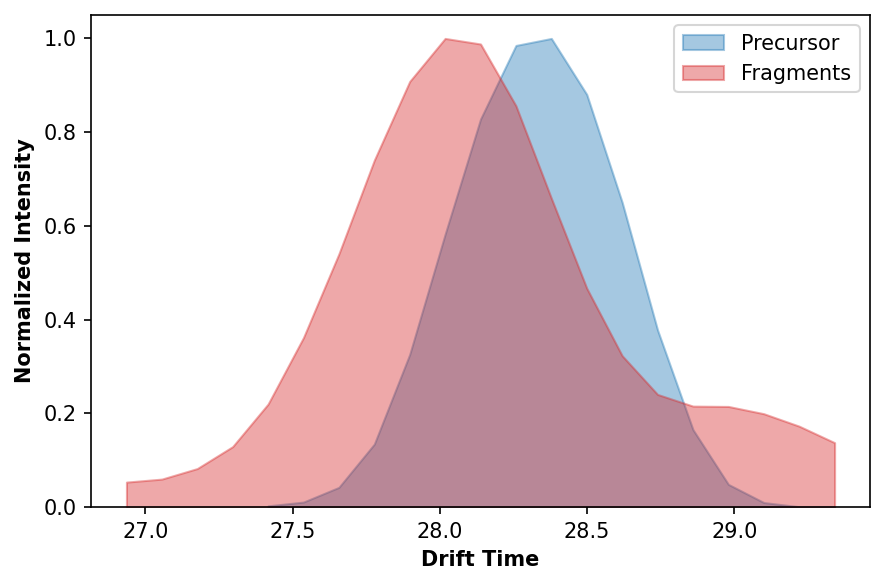

In [6]:
fig, ax = plt.subplots(1, dpi=150, facecolor='w')

ax.fill_between(precursor_dt['drift_time'],
                precursor_dt['intensity'] / precursor_dt['intensity'].max(),
                color='C0', alpha=0.4, label='Precursor')

ax.fill_between(fragment_dt['drift_time'],
                fragment_dt['intensity'] / fragment_dt['intensity'].max(),
                color='C3', alpha=0.4, label='Fragments')

ax.set_xlabel('Drift Time', fontweight='bold')
ax.set_ylabel('Normalized Intensity', fontweight='bold')
ax.set_ylim(0, None)
ax.legend()

plt.tight_layout()
plt.show()

Fortunately, fragment offset correction is handled within the DEIMoS's deconvolution module.
The model to correct for offset was built from TuneMix data acquired on both our IMS instrument and an Orbitrap.
Orbitrap MS1:MS2 pairs were used as ground truth, matching drift time information from the same MS1:MS2 pairs collected with IMS.
Ordinary least squares (OLS) regression was used to relate model inputs to predicted values.
The following model is supplied as default, but may be swapped out as needed.

In [7]:
def offset_correction_model(dt_ms2, mz_ms2, mz_ms1, ce=0,
                            params=[1.02067031, -0.02062323,  0.00176694]):
    # Cast params as array
    params = np.array(params).reshape(-1, 1)
    
    # Convert collision energy to array
    ce = np.ones_like(dt_ms2) * np.log(ce)
    
    # Create constant vector
    const = np.ones_like(dt_ms2)
    
    # Sqrt
    mu_ms1 = np.sqrt(mz_ms1)
    mu_ms2 = np.sqrt(mz_ms2)
    
    # Ratio
    mu_ratio = mu_ms2 / mu_ms1
    
    # Create dependent array
    x = np.stack((const, mu_ratio, ce), axis=1)
    
    # Predict
    y = np.dot(x, params).flatten() * dt_ms2
    
    return y

## Deconvolution

In [8]:
ms1_peaks = deimos.load('example_data_peaks.h5', key='ms1')
ms2_peaks = deimos.load('example_data_peaks.h5', key='ms2')

For computational efficiency, we will only consider MS1 features of high intensity (>1E4) and MS2 features at least 10% of the MS1 intensity (>1E3).

In [9]:
ms1_peaks = deimos.threshold(ms1_peaks, threshold=1E4)
ms2_peaks = deimos.threshold(ms2_peaks, threshold=1E3)

First, we'll instantiate the `MS2Deconvolution` class.

In [10]:
decon = deimos.deconvolution.MS2Deconvolution(ms1_peaks, ms1, ms2_peaks, ms2)

Next, putatively match MS1 and MS2 features to determine groupings in non-*m/z* dimensions (i.e. drift and retention time) for deconvolution.
The follwoing will match MS2 features to MS1 with offset between -0.12 ms and +1.4 ms in drift time and ±0.1 minutes in retention time.
The offset correction model is supplied here (we are using the pre-trained default).
The flag `require_ms1_greater_than_ms1` ensures that MS1 intensity must exceed MS2 intensity for putatively matched pairs.
Finally, `error_tolerance` signals the amount of acceptable error after the offset correction model is applied.

In [11]:
decon.construct_putative_pairs(dims=['drift_time', 'retention_time'],
                               low=[-0.12, -0.1], high=[1.4, 0.1], ce=20,
                               model=offset_correction_model,
                               require_ms1_greater_than_ms2=True,
                               error_tolerance=0.12)

,index_ms1,mz_ms1,drift_time_ms1,retention_time_ms1,intensity_ms1,persistence_ms1,index_ms2,mz_ms2,drift_time_ms2,retention_time_ms2,intensity_ms2,persistence_ms2,drift_time_raw_ms2,drift_time_error
0,0,144.101166,14.674946,7.258184,34796.207031,506.324219,11,144.101120,14.702256,7.238883,17817.498047,38.572266,14.657956,0.027310
1,0,144.101166,14.674946,7.258184,34796.207031,506.324219,13,144.102509,14.702866,7.238883,17105.628906,142.082031,14.658571,0.027920
2,0,144.101166,14.674946,7.258184,34796.207031,506.324219,14,144.102448,14.721763,7.277484,18313.193359,1513.085938,14.677596,0.046817
3,0,144.101166,14.674946,7.258184,34796.207031,506.324219,16,144.102463,14.690876,7.354833,15995.425781,21.912109,14.646501,0.015930
4,0,144.101166,14.674946,7.258184,34796.207031,506.324219,23,58.064362,14.713208,7.354834,16546.968750,2007.302734,14.577117,0.038263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,106,761.014832,29.930386,13.595733,12693.996094,12193.595199,1880,434.006134,29.956604,13.615034,1016.653931,124.465027,29.656542,0.026218
1147,106,761.014832,29.930386,13.595733,12693.996094,12193.595199,2269,515.005676,29.814772,13.615035,4266.412109,3606.785522,29.552746,0.115613
1148,106,761.014832,29.930386,13.595733,12693.996094,12193.595199,3113,434.005402,29.935779,13.499251,1186.000000,685.648323,29.635576,0.005394
1149,106,761.014832,29.930386,13.595733,12693.996094,12193.595199,3131,1007.023560,29.862866,13.537850,1132.000000,631.529305,29.790583,0.067520


The per-dimension bounds to consider for each feature must be specified using the `configure_profile_extraction` method.
Keyword arguments `low` and `high` indicate the upper and lower bound of each feature per dimension, and `relative` indicates whether to use relative or absolute tolerances per dimension.
No computation is performed here.

In [12]:
decon.configure_profile_extraction(dims=['mz', 'drift_time', 'retention_time'],
                                   low=[-200E-6, -0.05, -0.1],
                                   high=[600E-6, 0.05, 0.1],
                                   relative=[True, True, False])

Finally, we apply the configured deconvolution routine to yield a deconvolved result, signaling which dimensions to consider for the deconvolution with the `dims` keyword argument.
Specifying `resolution` signals the sampling interval of the interpolated profile, per dimension.
Computational cost scales with the dimensionality of the data and the number of putative MS1:MS2 pairs, and the number of data points in the raw data (since each profile requires a slice operation).
Below we will only evaluate quality of drift time profiles.

In [13]:
%%time
res = decon.apply(dims='drift_time', resolution=0.01)

CPU times: user 1min 6s, sys: 327 ms, total: 1min 6s
Wall time: 1min 6s


The data frame returned is in long format.
To yield the deconvolution result per MS1 feature, simply perform a `groupby` operation.
We filter by `drift_time_score` to keep only those fragment profiles with high agreement with the MS1 precursor.
Appropriate selection here depends on the quality of the offset correction.

In [14]:
res = res.loc[res['drift_time_score'] > 0.9].groupby(by=[x for x in res.columns if x.endswith('_ms1')],
                                                     as_index=False).agg(list).sort_values(by='persistence_ms1',
                                                                                           ascending=False).head(5)
res

,index_ms1,mz_ms1,drift_time_ms1,retention_time_ms1,intensity_ms1,persistence_ms1,index_ms2,mz_ms2,drift_time_ms2,retention_time_ms2,intensity_ms2,persistence_ms2,drift_time_raw_ms2,drift_time_error,drift_time_score
61,66,496.337463,28.336977,1.926034,47870.839844,47370.407699,"[9, 84, 112, 121, 191, 234, 381, 512, 572, 578...","[496.3372497558594, 478.3252868652344, 497.339...","[28.359545463198298, 28.280074184849394, 28.33...","[1.9067332744598389, 1.9453333616256714, 1.945...","[19621.005859375, 7959.99560546875, 6133.04687...","[375.21484375, 96.2119140625, 149.302734375, 3...","[28.264205932617188, 28.175649642944336, 28.23...","[0.022568458193415353, 0.05690282015548931, 0....","[0.994691902938733, 0.9912188303898247, 0.9856..."
92,97,192.094498,16.632273,9.035781,37407.832031,36907.446761,"[79, 207, 301, 326, 406, 433, 438, 586, 760, 9...","[148.10479736328125, 118.0657730102539, 118.06...","[16.645597499988735, 16.514533011318445, 16.51...","[8.977734565734863, 8.97773265838623, 9.093682...","[8243.1357421875, 4113.98193359375, 3061.89868...","[148.38232421875, 157.131103515625, 19.0856933...","[16.553136825561523, 16.393863677978516, 16.39...","[0.013324779651821217, 0.11773970901846909, 0....","[0.9863538882208794, 0.989537784254673, 0.9886..."
86,91,204.123215,17.011349,8.494816,36476.816406,35976.005355,"[128, 277, 699, 812, 1127, 1403, 2904, 2907, 2...","[85.05628967285156, 85.07498168945312, 85.0947...","[17.025378545289982, 17.01229256969094, 17.050...","[8.514116287231445, 8.514117240905762, 8.51411...","[5424.8583984375, 3419.12255859375, 1757.81372...","[64.27490234375, 113.87548828125, 87.561401367...","[16.858814239501953, 16.845661163330078, 16.88...","[0.014029820924747582, 0.000943845325704018, 0...","[0.9887982891868636, 0.9859095879326736, 0.976..."
85,90,118.086433,13.758590,8.224499,36248.109375,35747.372542,"[45, 159, 310, 549, 836, 945, 1102, 1173, 1191...","[59.07223129272461, 118.0858383178711, 58.0918...","[13.790750275478697, 13.789786160412664, 13.75...","[8.320982933044434, 8.166616439819336, 8.20520...","[12710.3955078125, 4892.4521484375, 3134.25, 2...","[476.71484375, 77.00244140625, 129.80932617187...","[13.689501762390137, 13.755182266235352, 13.64...","[0.03216053091082571, 0.031196415844792824, 0....","[0.9782737511259236, 0.975511013881835, 0.9826..."
82,87,144.101120,14.669243,7.181000,34877.378906,34377.263167,"[11, 13, 14, 28, 342, 468, 536, 541, 612, 645,...","[144.1011199951172, 144.10250854492188, 144.10...","[14.702256094352368, 14.702865879642017, 14.72...","[7.2388834953308105, 7.2388834953308105, 7.277...","[17817.498046875, 17105.62890625, 18313.193359...","[38.572265625, 142.08203125, 1513.0859375, 233...","[14.65795612335205, 14.658571243286133, 14.677...","[0.03301323546564916, 0.03362302075529833, 0.0...","[0.9893036466315329, 0.9893071239016104, 0.990..."


Visualize fragmentation spectra of the highest intensity MS1 feature:

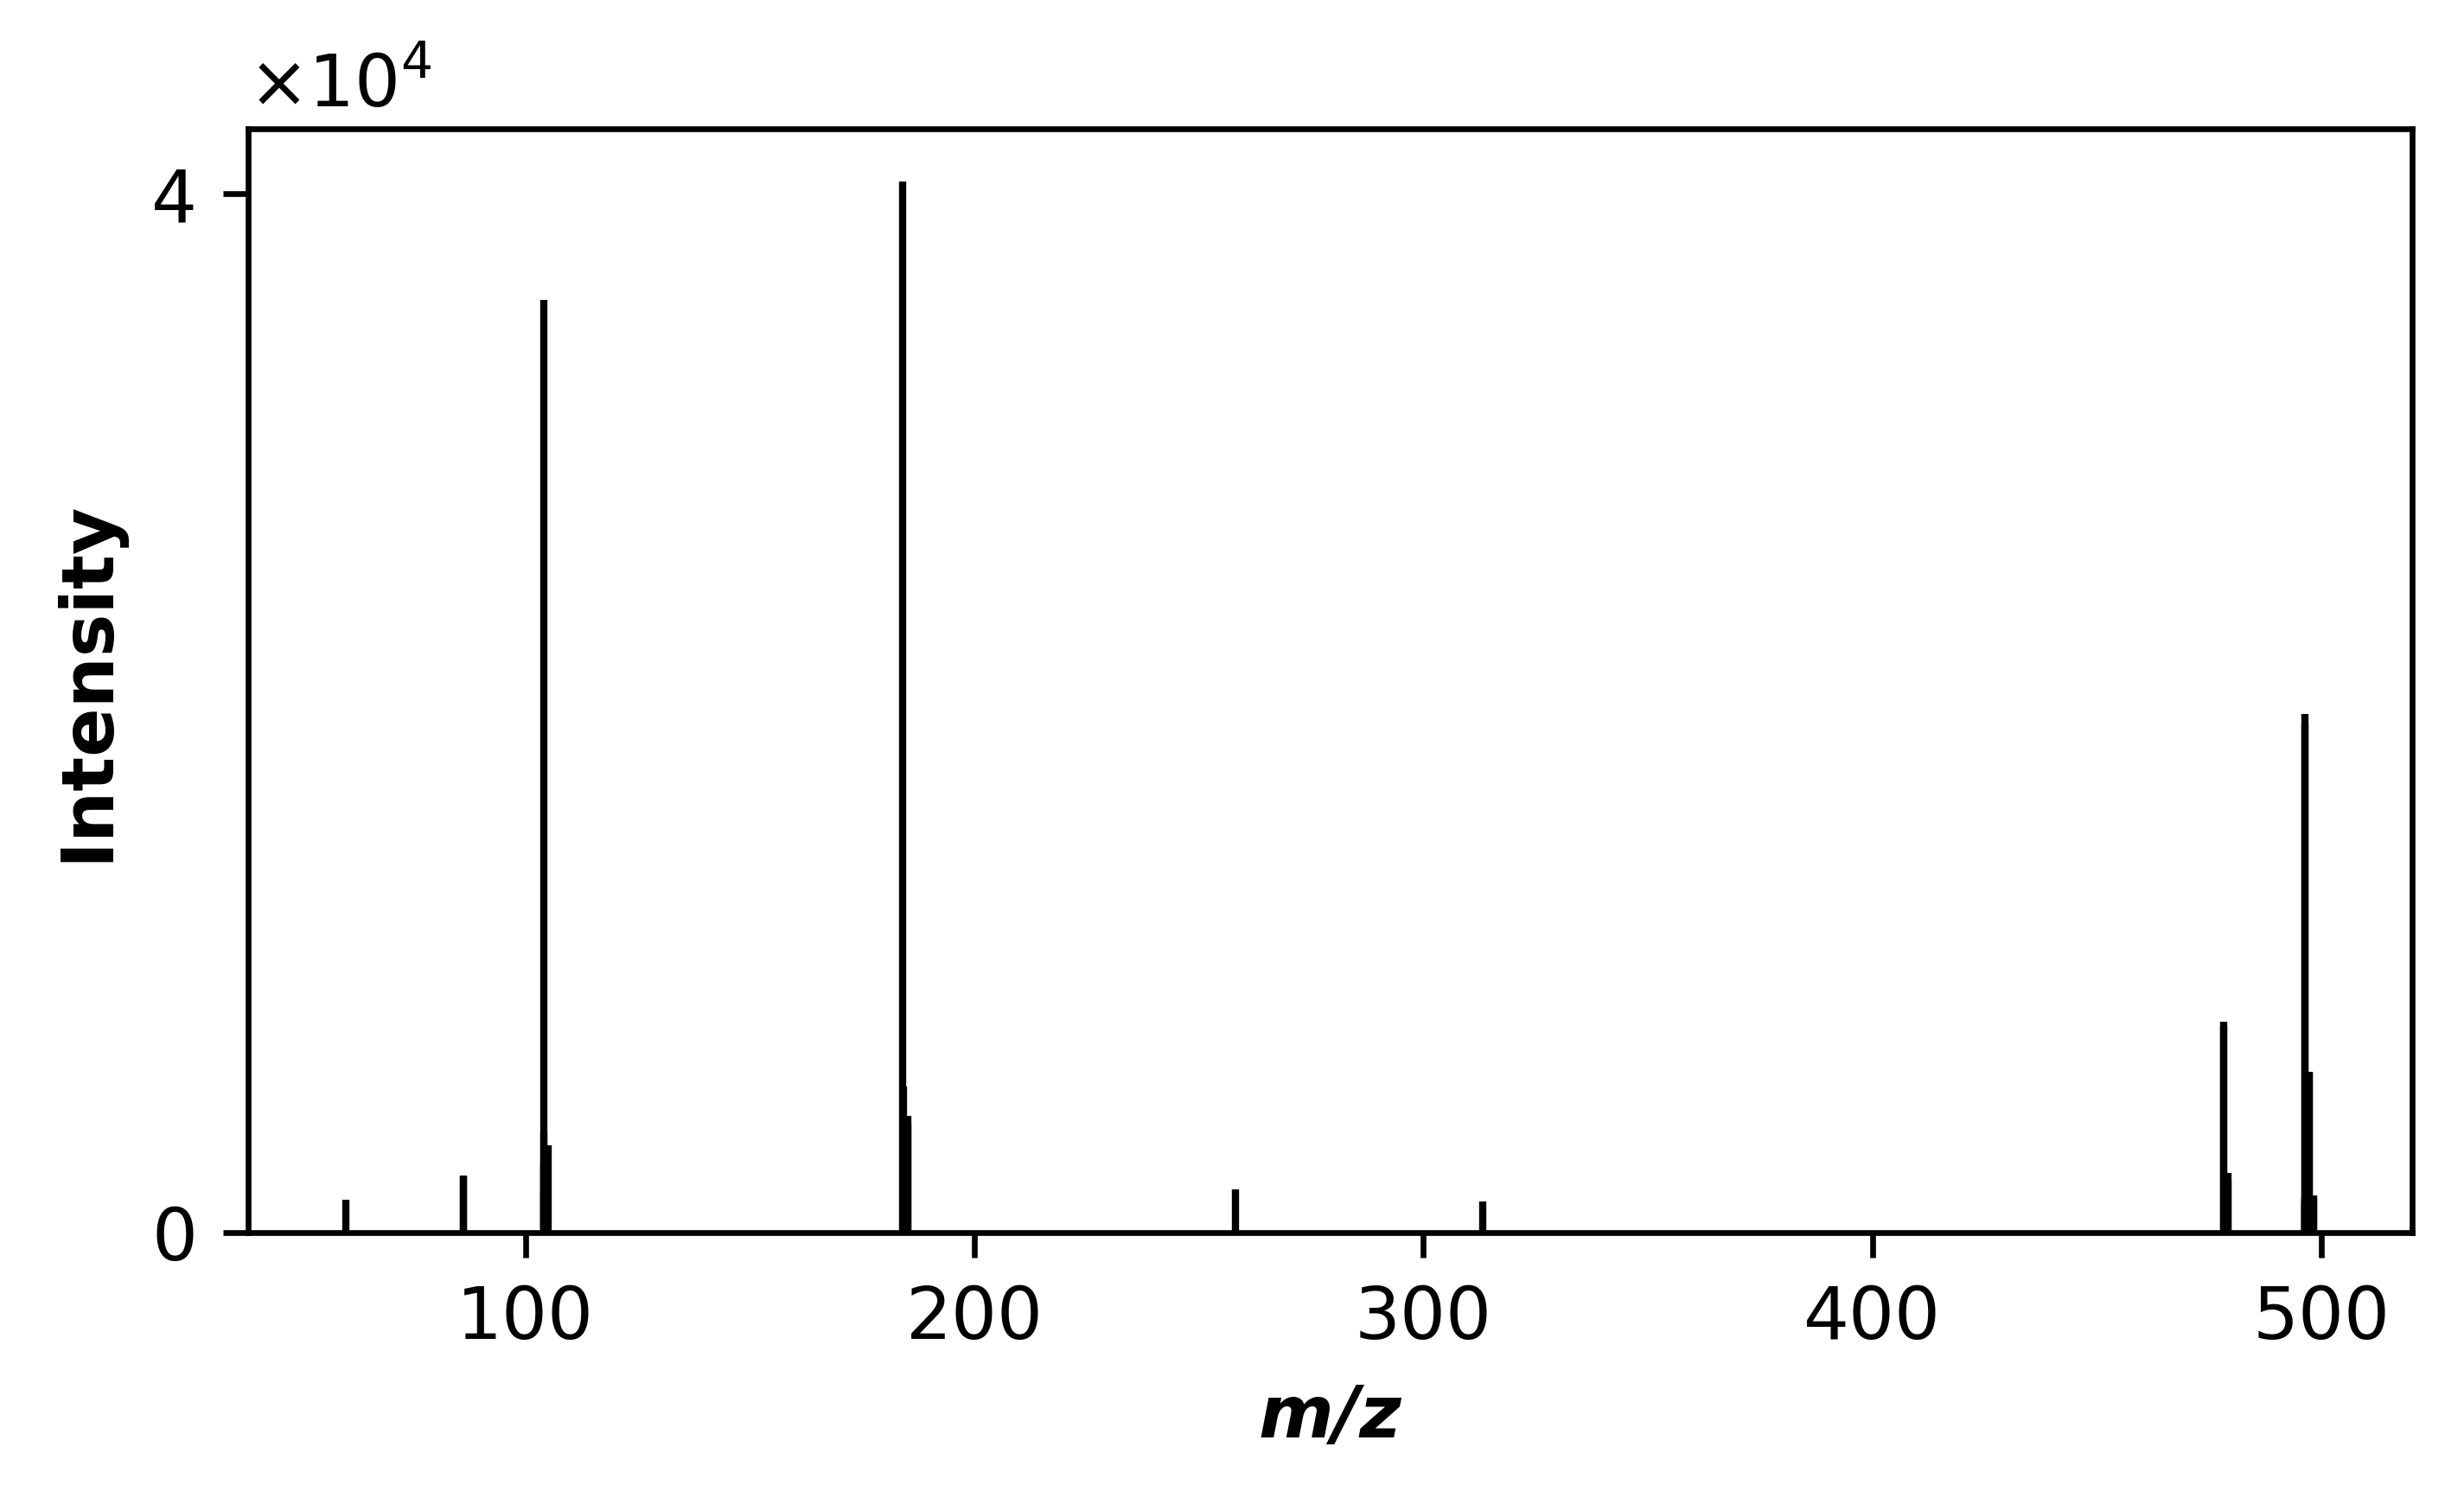

In [15]:
deimos.plot.stem(np.array(res.loc[61, 'mz_ms2']),
                 np.array(res.loc[61, 'intensity_ms2']),
                 width=1)
plt.tight_layout()
plt.show()